In [ ]:
!pip install tensorflow matplotlib seaborn pillow scikit-learn deepstack

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow import keras
from deepstack.base import KerasMember
import requests
from io import BytesIO
import cv2
from glob import glob

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/dataset_augmented"

In [ ]:
inme_var_path = os.path.join(DATASET_PATH, "İnmeVar")
inme_yok_path = os.path.join(DATASET_PATH, "İnmeYok")

In [ ]:
# Tüm dosya yollarını al ve etiketle
inme_var_files = sorted(glob(os.path.join(inme_var_path, "*.png")))
inme_yok_files = sorted(glob(os.path.join(inme_yok_path, "*.png")))

In [ ]:
# İnme Var ve İnme Yok görsellerinin sayısını yazdır
inme_var_count = len(inme_var_files)
inme_yok_count = len(inme_yok_files)

print(f"İnme Var Görselleri Sayısı: {inme_var_count}")
print(f"İnme Yok Görselleri Sayısı: {inme_yok_count}")

İnme Var Görselleri Sayısı: 13302
İnme Yok Görselleri Sayısı: 9088


In [ ]:
# DataFrame oluştur
data = pd.DataFrame({
    "image_path": inme_var_files + inme_yok_files,
    "label": [1] * len(inme_var_files) + [0] * len(inme_yok_files)  # 1: İnme Var, 0: İnme Yok
})

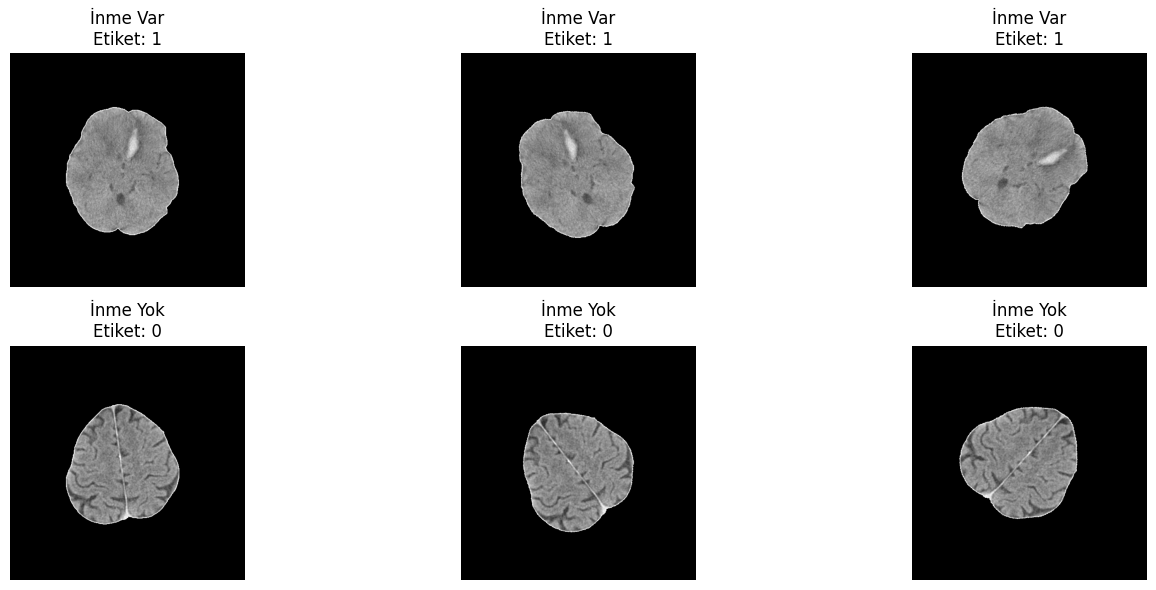

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# İnme Var ve İnme Yok görsellerinin ilk 3 örneğini al
inme_var_first_3 = data.iloc[:3]
inme_yok_first_3 = data.iloc[len(inme_var_files):len(inme_var_files)+3]

# Plot başlatma
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 2 satır, 3 sütun

# İnme Var görselleri
for i, (index, row) in enumerate(inme_var_first_3.iterrows()):
    img = Image.open(row["image_path"]).convert("RGB")  # Görseli RGB'ye dönüştür
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'İnme Var\nEtiket: {row["label"]}')
    axes[0, i].axis('off')  # Eksenleri kapat

# İnme Yok görselleri
for i, (index, row) in enumerate(inme_yok_first_3.iterrows()):
    img = Image.open(row["image_path"]).convert("RGB")  # Görseli RGB'ye dönüştür
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'İnme Yok\nEtiket: {row["label"]}')
    axes[1, i].axis('off')  # Eksenleri kapat

    # Dosya adını görselin üzerine yazdır


# Görselleri göster
plt.tight_layout()
plt.show()



Görsel Yükleniyor: 100%|██████████| 22390/22390 [00:00<00:00, 5123320.60it/s]


Yüklenen görsellerin sayısı: 22390
İlk Görsel Yolu: /content/drive/MyDrive/dataset_augmented/İnmeVar/10002_1.png
İlk Etiket: 1


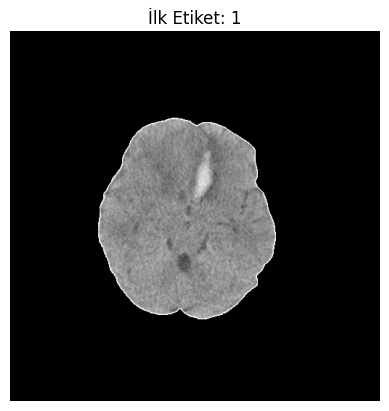

In [ ]:
import cv2
import numpy as np
import multiprocessing
from tqdm import tqdm

IMG_SIZE = (224, 224)

def process_image(img_path, label):
    # Görseli okuma
    img = cv2.imread(img_path)

    # Eğer görsel yüklenememişse, None döndür
    if img is None:
        print(f"Bozuk veya geçersiz görsel: {img_path}")
        return None, None

    # Görseli RGB'ye dönüştürme
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Görseli yeniden boyutlandırma
    img = cv2.resize(img, IMG_SIZE)

    # Normalizasyon: Piksel değerlerini [0, 1] aralığına getirme
    img = img.astype("float32") / 255.0

    return img, label

def load_and_preprocess_images(image_paths, labels):
    images = []
    valid_image_paths = []  # Geçerli görsel yollarını burada tutacağız
    valid_labels = []  # Geçerli etiketler

    # İlk görsel ve etiketi almak için
    first_image_path = None
    first_label = None

    # multiprocessing ile paralel işlem için argümanları oluşturuyoruz
    args = list(zip(image_paths, labels))

    # multiprocessing ile işlem paralelleştirilmiş
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = list(tqdm(pool.starmap(process_image, args), total=len(image_paths), desc="Görsel Yükleniyor"))

    # Sonuçları işle
    for i, (img, label) in enumerate(results):
        if img is not None:
            if first_image_path is None:
                first_image_path = image_paths[i]
                first_label = label

            images.append(img)
            valid_image_paths.append(image_paths[i])  # Geçerli görsel yolunu ekle
            valid_labels.append(label)  # Geçerli etiketi ekle

    # Görselleri ve etiketleri numpy dizilerine dönüştürme
    images = np.array(images)
    labels = np.array(valid_labels)

    # İlk görseli ve etiketini döndürme
    return images, labels, first_image_path, first_label

# Örnek kullanım
X, y, first_img_path, first_label = load_and_preprocess_images(inme_var_files + inme_yok_files,
                                                               [1]*len(inme_var_files) + [0]*len(inme_yok_files))

print(f"Yüklenen görsellerin sayısı: {len(X)}")

# İlk görseli ve etiketini yazdırma
print(f"İlk Görsel Yolu: {first_img_path}")
print(f"İlk Etiket: {first_label}")

# İlk görseli görselleştirme
first_img = cv2.imread(first_img_path)
first_img = cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt
plt.imshow(first_img)
plt.title(f"İlk Etiket: {first_label}")
plt.axis('off')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Veriyi %70 eğitim, %15 doğrulama, %15 test olarak ayır
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Bölünen veri miktarlarını yazdırma
print(f"Eğitim verisi: {len(X_train)}")
print(f"Doğrulama verisi: {len(X_val)}")
print(f"Test verisi: {len(X_test)}")



Eğitim verisi: 15673
Doğrulama verisi: 3358
Test verisi: 3359


In [ ]:
!pip install pyswarm


  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=be7253a31b7c3a43df66e341f71b6141ca1f5c15eca1044f6ff3e6215df3230c
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Input, BatchNormalization, GlobalAveragePooling2D, Reshape)
from pyswarm import pso
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score
from tqdm import tqdm
import multiprocessing
import time

# CNN + LSTM Modeli Tanımlama
def create_cnn_lstm_model(lstm_units=256, dropout_rate=0.4, learning_rate=0.0005):
    input_layer = Input(shape=(224, 224, 3))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    x = Reshape((1, 512))(x)  # LSTM için zaman serisi formatına getirme
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = LSTM(lstm_units // 2, return_sequences=False)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=x)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# PSO ile Optimizasyon Fonksiyonu
def objective_function(params):
    lstm_units, dropout_rate, learning_rate = params
    model = create_cnn_lstm_model(int(lstm_units), dropout_rate, learning_rate)

    # Modeli Eğit
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Validation loss ve F1 skoru hesapla
    val_loss = min(history.history['val_loss'])

    # Tahminleri al
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    f1 = f1_score(y_val, y_pred)

    # İki metrik üzerinde optimizasyon yap: Validation Loss ve F1 Score
    return val_loss - f1  # Minimize etmek için bu farkı hedefliyoruz

# PSO Parametrelerinin Aralıkları
lb = [64, 0.2, 0.0001]  # alt sınırlar: lstm_units, dropout_rate, learning_rate
ub = [256, 0.5, 0.01]   # üst sınırlar: lstm_units, dropout_rate, learning_rate

# PSO'yu Çalıştırma - Paralel İterasyonlar
def pso_with_multiprocessing(objective_function, lb, ub, swarmsize=10, maxiter=10):
    best_params = None

    with tqdm(total=maxiter, desc="PSO Iterations") as pbar:
        start_time = time.time()  # Başlangıç zamanı

        # multiprocessing Pool oluşturuyoruz
        with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
            # PSO'yu çalıştırıyoruz ve her iterasyonu paralel olarak işliyoruz
            for i in range(maxiter):
                iteration_start = time.time()  # Her iterasyonun başlangıç zamanı
                best_params, _ = pso(objective_function, lb, ub, swarmsize=swarmsize, maxiter=1)  # 1 iterasyon için çalıştır

                # Geçen süreyi hesapla
                iteration_duration = time.time() - iteration_start
                remaining_iterations = maxiter - (i + 1)
                remaining_time = remaining_iterations * iteration_duration  # Kalan tahmini süre

                # İterasyonla ilgili bilgiyi tqdm'ye ekle
                pbar.set_postfix({
                    'Time/Iter': f'{iteration_duration:.2f}s',
                    'Remaining Time': f'{remaining_time:.2f}s'
                })
                pbar.update(1)  # her iterasyonda ilerlemeyi güncelle

    return best_params



# PSO ile optimizasyonu başlat
best_params = pso_with_multiprocessing(objective_function, lb, ub, swarmsize=5, maxiter=5)





PSO Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PSO Iterations:  20%|██        | 1/5 [19:15<1:17:03, 1155.76s/it, Time/Iter=1152.00s, Remaining Time=4608.00s]

Stopping search: maximum iterations reached --> 1
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PSO Iterations:  40%|████      | 2/5 [38:27<57:41, 1153.67s/it, Time/Iter=1152.21s, Remaining Time=3456.62s]  

Stopping search: maximum iterations reached --> 1
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PSO Iterations:  60%|██████    | 3/5 [57:49<38:34, 1157.18s/it, Time/Iter=1161.35s, Remaining Time=2322.70s]

Stopping search: maximum iterations reached --> 1
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PSO Iterations:  80%|████████  | 4/5 [1:17:00<19:14, 1155.00s/it, Time/Iter=1151.66s, Remaining Time=1151.66s]

Stopping search: maximum iterations reached --> 1
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


PSO Iterations: 100%|██████████| 5/5 [1:36:15<00:00, 1154.69s/it, Time/Iter=1154.13s, Remaining Time=0.00s]

Stopping search: maximum iterations reached --> 1


PSO Iterations: 100%|██████████| 5/5 [1:36:16<00:00, 1155.26s/it, Time/Iter=1154.13s, Remaining Time=0.00s]


In [ ]:
# En İyi Parametrelerle Modeli Eğitme
best_lstm_units, best_dropout_rate, best_learning_rate = best_params
model = create_cnn_lstm_model(int(best_lstm_units), best_dropout_rate, best_learning_rate)


In [ ]:
import json

# Kaydedilecek dizini belirle
file_path = "/content/drive/My Drive/best_params.json"

# En iyi parametreleri JSON olarak kaydet
best_params_dict = {
    "lstm_units": int(best_params[0]),
    "dropout_rate": float(best_params[1]),
    "learning_rate": float(best_params[2])
}

with open(file_path, "w") as f:
    json.dump(best_params_dict, f, indent=4)

print(f"En iyi parametreler Drive'a kaydedildi: {file_path}")



En iyi parametreler Drive'a kaydedildi: /content/drive/My Drive/best_params.json


In [ ]:
import json

# JSON dosyasının yolu
file_path = "/content/drive/MyDrive/best_params.json"

# JSON dosyasını yükleme
with open(file_path, "r") as f:
    best_params = json.load(f)

print("En iyi parametreler yüklendi:", best_params)



En iyi parametreler yüklendi: {'lstm_units': 221, 'dropout_rate': 0.25891690856780236, 'learning_rate': 0.0009251449617728362}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks tanımla
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Modeli eğit
history = model.fit(
    X_train, y_train,
    epochs=50,  # Daha fazla epoch ama early stopping ile duracak
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.7476 - loss: 0.5004 - val_accuracy: 0.5941 - val_loss: 2.7817 - learning_rate: 9.2514e-04
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.8416 - loss: 0.3573 - val_accuracy: 0.5941 - val_loss: 3.1423 - learning_rate: 9.2514e-04
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.8571 - loss: 0.3276 - val_accuracy: 0.6849 - val_loss: 1.4511 - learning_rate: 9.2514e-04
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.8670 - loss: 0.3040 - val_accuracy: 0.4381 - val_loss: 1.5817 - learning_rate: 9.2514e-04
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.8894 - loss: 0.2732 - val_accuracy: 0.4253 - val_loss: 2.1654 - learning_rate: 9.2514e-04
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9008 - loss: 0.2437 - val_accuracy: 0.4872 - val_loss: 1.7991 - learning_rate: 9.2514e-04
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/ste

In [ ]:
# Modeli Drive’a kaydetme yolu
model_path = "/content/drive/My Drive/stroke_detection_model.h5"

# Modeli kaydet
model.save(model_path)

print(f"Model başarıyla Google Drive'a kaydedildi: {model_path}")


Model başarıyla Google Drive'a kaydedildi: /content/drive/My Drive/stroke_detection_model.h5


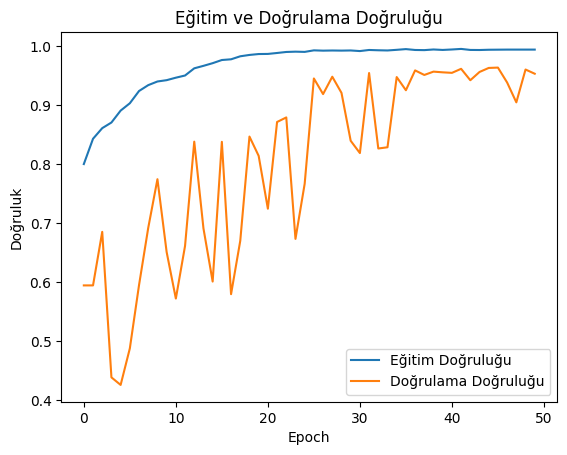

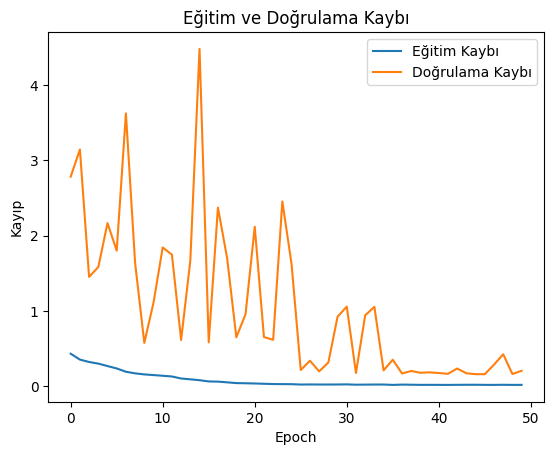

In [ ]:
# Eğitim Tarihçesini Görselleştirme
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Eğitim Tarihçesini Görselleştirme
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()


In [ ]:
# Modeli Değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9683 - loss: 0.1092
Test Loss: 0.13556498289108276, Test Accuracy: 0.9630842804908752


In [ ]:
# Tahmin Yapma
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)  # 0.5 eşik değeri ile sınıflandırma

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1363
           1       0.97      0.97      0.97      1996

    accuracy                           0.96      3359
   macro avg       0.96      0.96      0.96      3359
weighted avg       0.96      0.96      0.96      3359

Ortalama F1-score: 0.9617


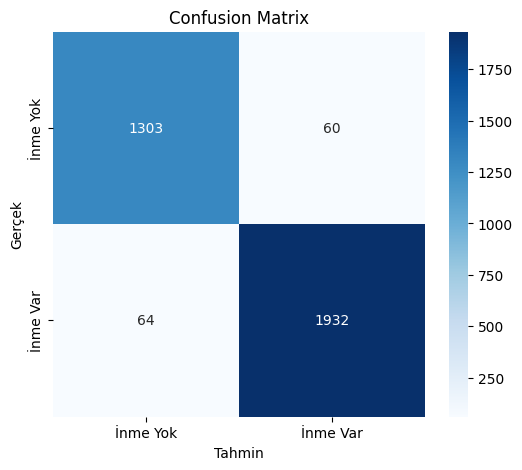

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Classification Report ve Confusion Matrix
report = classification_report(y_test, y_pred_class, output_dict=True)

# Ortalama F1-score hesapla (Makro Ortalama kullanarak)
average_f1_score = report['macro avg']['f1-score']

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

print(f"Ortalama F1-score: {average_f1_score:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['İnme Yok', 'İnme Var'], yticklabels=['İnme Yok', 'İnme Var'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


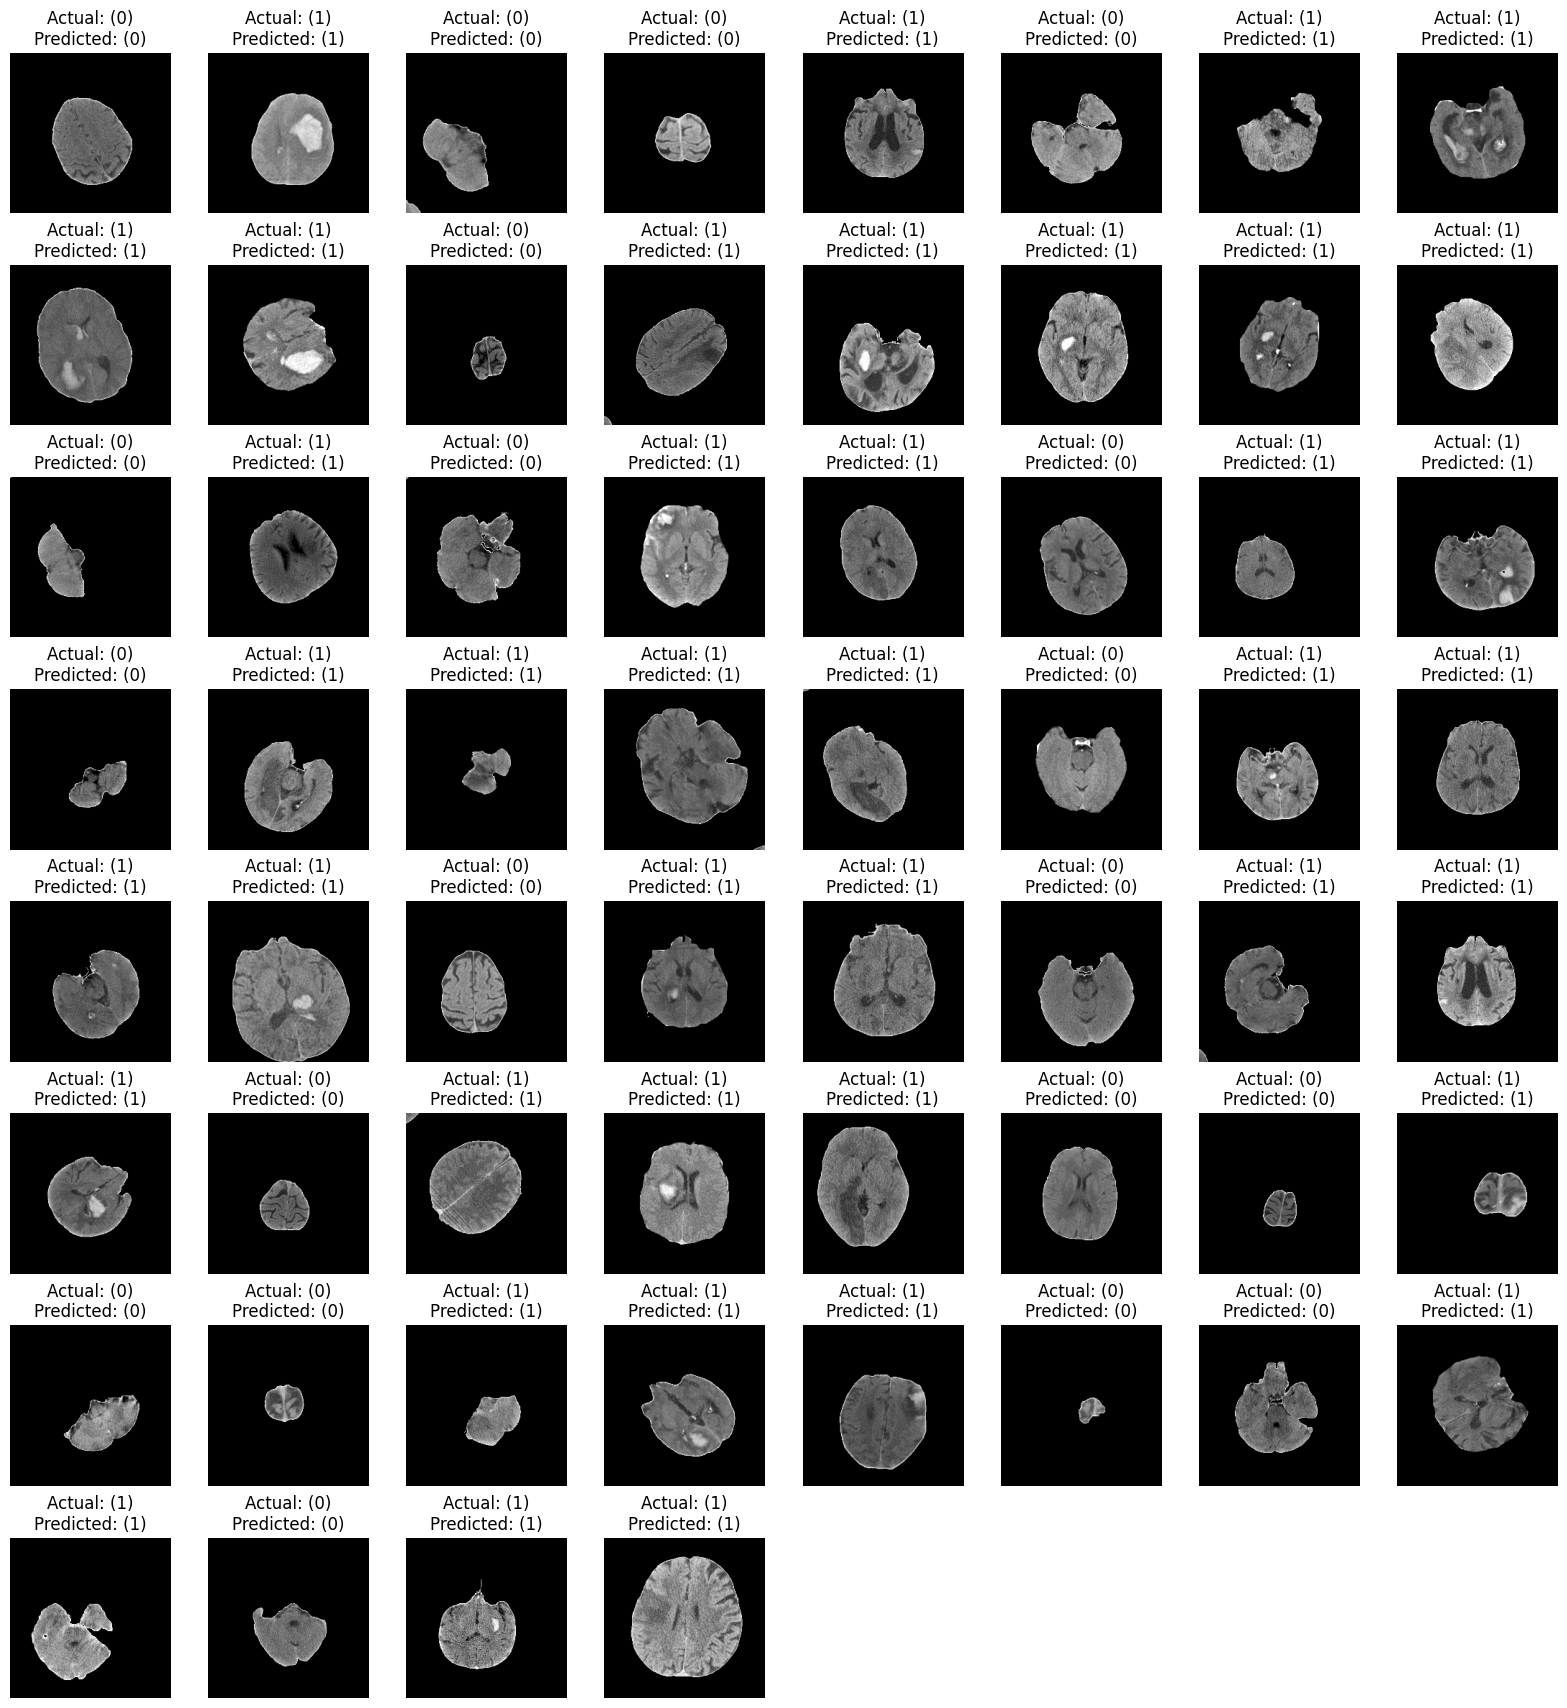

In [ ]:
import matplotlib.pyplot as plt

# Sınıf isimleri
class_labels = ["(0)", "(1)"]

# Test verisi üzerinden tahminleri al
y_pred_probs = model.predict(X_test)
y_pred_test_label = (y_pred_probs > 0.5).astype(int).flatten()  # Tahmin edilen sınıflar

# Görselleştirme için rastgele 30 örnek seç
plt.figure(figsize=(16, 32))

for i in range(60):
    plt.subplot(15, 8, i + 1)

    # Görüntüyü göster
    plt.imshow(X_test[i], cmap='gray')  # Gri tonlama ise cmap='gray' ekledik

    # Gerçek ve Tahmini Etiketleri Göster
    plt.title(f"Actual: {class_labels[y_test[i]]}\nPredicted: {class_labels[y_pred_test_label[i]]}")

    plt.axis("off")

plt.tight_layout()
plt.show()